In [1]:
import os
import sys
# sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
import pickle
import wandb
from pathlib import Path
from tqdm.notebook import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import GroupKFold

In [2]:
CFG = {
    'seed': 0,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 8,
    'train_bs': 80, 
    'valid_bs': 32,
    'lr': 1e-4, 
    'weight_decay': 1e-8,
    'num_workers': 0
}


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
def expand_contact_id(df):
    """
    Splits out contact_id into separate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

labels = expand_contact_id(pd.read_csv("data/sample_submission.csv"))

tracking = pd.read_csv("data/test_player_tracking.csv")

helmets = pd.read_csv("data/test_baseline_helmets.csv")

video_metadata = pd.read_csv("data/test_video_metadata.csv")

## Sync one-hots

In [ ]:
with open('cache/team_roles.pkl', 'rb') as f:
    team_roles = pickle.load(f)

In [38]:
onehots = []
for role in team_roles:
    onehots.append((tracking['position'] == role).astype('int').rename(role))
tracking = tracking.drop('position', axis=1).join(pd.concat(onehots, axis=1))

In [39]:
tracking

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,jersey_number,x_position,y_position,...,OT,P,QB,RB,S,SAF,SS,T,TE,WR
0,58172_003247,58172,3247,41937,2020-09-13T19:30:20.200Z,-272,home,57,64.28,11.29,...,0,0,0,0,0,0,0,0,0,0
1,58172_003247,58172,3247,45345,2020-09-13T19:30:20.200Z,-272,away,50,76.03,36.74,...,0,0,0,0,0,0,0,0,0,0
2,58172_003247,58172,3247,46205,2020-09-13T19:30:20.200Z,-272,home,98,65.64,15.74,...,0,0,0,0,0,0,0,0,0,0
3,58172_003247,58172,3247,43406,2020-09-13T19:30:20.200Z,-272,home,14,36.35,14.94,...,0,0,0,0,0,0,0,0,0,1
4,58172_003247,58172,3247,48233,2020-09-13T19:30:20.200Z,-272,away,45,76.10,32.15,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14867,58168_003392,58168,3392,43395,2020-09-11T03:01:57.300Z,92,away,23,51.03,13.63,...,0,0,0,0,0,0,0,0,0,0
14868,58168_003392,58168,3392,39947,2020-09-11T03:01:57.300Z,92,home,72,42.73,18.52,...,0,0,0,0,0,0,0,1,0,0
14869,58168_003392,58168,3392,44822,2020-09-11T03:01:57.300Z,92,home,15,35.01,18.68,...,0,0,1,0,0,0,0,0,0,0
14870,58168_003392,58168,3392,38590,2020-09-11T03:01:57.300Z,92,home,70,43.72,18.24,...,0,0,0,0,0,0,0,0,0,0


In [40]:
def calculate_cog(players):
    n = len(players)
    cog_x, cog_y = 0, 0
    
    for player in players:
        cog_x += player[2]
        cog_y += player[3]
    if n != 0:
        cog_x /= n 
        cog_y /= n
    
    return cog_x, cog_y, n

In [41]:
zones = [2, 4, 6]

In [42]:
snapshots = tracking[["game_play", "step"]].drop_duplicates().reset_index(drop=True).values
col_idx = {col : i for i, col in enumerate(tracking.columns)} 

chunks = []
for snapshot in tqdm(snapshots, total=len(snapshots)):
    # Get player-pos configuration within 1 step of game_play
    positions_df = (tracking[(tracking['game_play'] == snapshot[0]) & \
                              (tracking['step'] == snapshot[1])])
    positions = positions_df.values

    neighbors = {}
    i = 0
    # Calculate all distances between players
    for player1 in positions:
        i += 1
        neighbors.setdefault(player1[col_idx['nfl_player_id']], {})
        for player2 in positions[i:]:
            if player1[col_idx['nfl_player_id']] != player2[col_idx['nfl_player_id']]:
                distance = math.sqrt((player1[col_idx['x_position']] - player2[col_idx['x_position']])**2 + \
                                     (player1[col_idx['y_position']] - player2[col_idx['y_position']])**2)

                ally = player1[col_idx['team']] == player2[col_idx['team']]

                relative_x = (player2[col_idx['x_position']] - player1[col_idx['x_position']])
                relative_y = (player2[col_idx['y_position']] - player1[col_idx['y_position']])            

                # Fill both players distances to each other
                neighbors.setdefault(player2[col_idx['nfl_player_id']], {})
                neighbors[player1[col_idx['nfl_player_id']]][player2[col_idx['nfl_player_id']]] = \
                    (distance, ally, relative_x, relative_y)
                neighbors[player2[col_idx['nfl_player_id']]][player1[col_idx['nfl_player_id']]] = \
                    (distance, ally, -relative_x, -relative_y)


    # Find Allies/Enemies/Players in radius {z} of target player; iterate over zones
    zones.sort()
    # Create dict for dataframe extension
    extension = {}
    for zone in sorted(zones):
        extension.setdefault("allies_cog_x_" + str(zone), [])
        extension.setdefault("allies_cog_y_" + str(zone), [])
        extension.setdefault("allies_number_" + str(zone), [])

        extension.setdefault("enemies_cog_x_" + str(zone), [])
        extension.setdefault("enemies_cog_y_" + str(zone), [])
        extension.setdefault("enemies_number_" + str(zone), [])

    # Fill all series in player(like in tracking df) order
    for player1 in positions:
        pid = player1[col_idx['nfl_player_id']]
        # Sort neighbors by distance
        nbrs = sorted(neighbors[pid].items(), key=lambda item: item[1][0])
        i = 0
        for zone in sorted(zones):
            allies = []
            enemies = []
            # While distance to ith is less than zone radius
            while i < len(nbrs) and nbrs[i][1][0] < zone:
                # If ally
                if nbrs[i][1][1]:
                    allies.append(nbrs[i][1])
                else:
                    enemies.append(nbrs[i][1])
                i += 1

            # Calculate center of gravity features
            ally_cog_x, ally_cog_y, ally_num = calculate_cog(allies)
            enemy_cog_x, enemy_cog_y, enemy_num = calculate_cog(enemies)

            extension["allies_cog_x_" + str(zone)].append(ally_cog_x)
            extension["allies_cog_y_" + str(zone)].append(ally_cog_y)
            extension["allies_number_" + str(zone)].append(ally_num)

            extension["enemies_cog_x_" + str(zone)].append(enemy_cog_x)
            extension["enemies_cog_y_" + str(zone)].append(enemy_cog_y)
            extension["enemies_number_" + str(zone)].append(enemy_num)
    
    # Create chunk of DF
    chunk = positions_df.reset_index(drop=True).join(pd.DataFrame.from_dict(extension))
    chunks.append(chunk)

# Concat slices and merge to df_combo
tracking_extended = pd.concat(chunks).reset_index(drop=True)

  0%|          | 0/676 [00:00<?, ?it/s]

In [30]:
os.makedirs("work/test/frames", exist_ok=True)

for video in tqdm(helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i data/test/{video} -q:v 2 -f image2 work/test/frames/{video}_%04d.jpg -hide_banner -loglevel error

  0%|          | 0/481 [00:00<?, ?it/s]

In [44]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"], zones=[]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
] + team_roles

contexts = ['allies_cog_x_', 'allies_cog_y_', 'allies_number_',
            'enemies_cog_x_', 'enemies_cog_y_', 'enemies_number_']

for zone in zones:
    use_cols.extend(list(map(lambda s: s + str(zone), contexts)))

test, feature_cols = create_features(labels, tracking_extended, use_cols=use_cols)
test

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,enemies_cog_y_4_2,enemies_number_4_2,allies_cog_x_6_2,allies_cog_y_6_2,allies_number_6_2,enemies_cog_x_6_2,enemies_cog_y_6_2,enemies_number_6_2,distance,G_flug
0,58168_003392_0_37084_37211,0,58168_003392,0,37084,37211,41.90,20.08,0.54,0.06,...,1.365,2.0,0.640000,4.700000,1.0,5.620000,1.550,1.0,3.794232,False
1,58168_003392_0_37084_38556,0,58168_003392,0,37084,38556,41.90,20.08,0.54,0.06,...,-1.720,1.0,0.170000,-4.030000,1.0,-1.710000,-4.605,2.0,10.530043,False
2,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,-0.060,2.0,-0.040000,5.400000,1.0,4.840000,-1.260,1.0,1.543017,False
3,58168_003392_0_37084_38590,0,58168_003392,0,37084,38590,41.90,20.08,0.54,0.06,...,-0.565,2.0,0.040000,-5.400000,1.0,2.903333,-0.420,3.0,5.431841,False
4,58168_003392_0_37084_39947,0,58168_003392,0,37084,39947,41.90,20.08,0.54,0.06,...,0.000,0.0,0.120000,-4.960000,1.0,1.855000,0.000,2.0,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49583,58172_003247_125_52521_52939,0,58172_003247,125,52521,52939,23.44,4.04,1.41,0.15,...,-1.555,2.0,-4.686667,0.253333,3.0,-2.610000,-3.790,2.0,14.629204,False
49584,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
49585,58172_003247_125_52852_52939,0,58172_003247,125,52852,52939,32.67,2.18,2.34,0.24,...,-1.555,2.0,-4.686667,0.253333,3.0,-2.610000,-3.790,2.0,5.270607,False
49586,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [50]:
test_filtered = test.query('not distance>2').reset_index(drop=True)
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1
test_filtered

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,enemies_number_4_2,allies_cog_x_6_2,allies_cog_y_6_2,allies_number_6_2,enemies_cog_x_6_2,enemies_cog_y_6_2,enemies_number_6_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,2.0,-0.04,5.40,1.0,4.840000,-1.26,1.0,1.543017,False,300
1,58168_003392_0_37084_G,0,58168_003392,0,37084,G,41.90,20.08,0.54,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,0,58168_003392,0,37211,46445,39.59,17.07,0.53,0.05,...,2.0,-0.20,5.45,2.0,3.986667,0.94,3.0,1.258014,False,300
3,58168_003392_0_37211_G,0,58168_003392,0,37211,G,39.59,17.07,0.53,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,0,58168_003392,0,38556,G,41.93,30.61,0.67,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,58172_003247_125_48241_G,0,58172_003247,125,48241,G,33.86,-1.28,0.79,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6627,58172_003247_125_48335_G,0,58172_003247,125,48335,G,44.74,3.16,4.72,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6628,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6629,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049


In [51]:
del test, labels, tracking
gc.collect()

63

In [52]:
video2helmets = {}
helmets_new = helmets.set_index('video')
for video in tqdm(helmets.video.unique()):
    video2helmets[video] = helmets_new.loc[video].reset_index(drop=True)
    
del helmets, helmets_new
gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

18

In [54]:
video2last_frame = {}
video2first_frame = {}

for game_play in tqdm(video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        frames = list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'work/test/frames/{video}*')))
        video2first_frame[video] = min(frames)
        video2last_frame[video] = max(frames)

  0%|          | 0/2 [00:00<?, ?it/s]

# Dataset

In [57]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [60]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.labels = df.contact.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
            tmp = tmp[tmp.nfl_player_id.isin(players)]
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and video2first_frame[video] <= f <= video2last_frame[video]:
                    img = cv2.imread(f'work/test/frames/{video}_{f:04d}.jpg', 0)
                    
                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    pad_y = (256 - img.shape[0]) // 2
                    pad_x = (256 - img.shape[1]) // 2
                    img_new[pad_y:pad_y+img.shape[0], pad_x:pad_x+img.shape[1]] = img
                    
                imgs.append(img_new)
                
        feature = np.float32(self.feature[idx])
        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.labels[idx])

        return img, feature, label

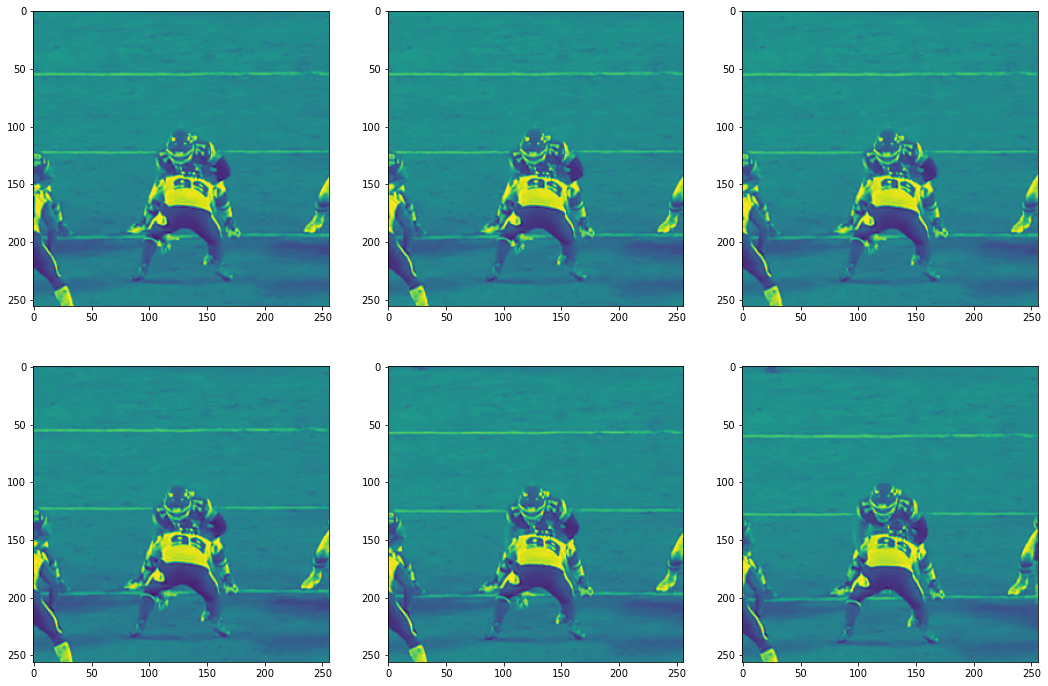

(torch.Size([26, 256, 256]),
 array([ 4.1900002e+01,  2.0080000e+01,  5.4000002e-01,  5.9999999e-02,
         2.5269000e+02,  2.6231000e+02,  9.2000002e-01,  8.9999998e-01,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.5300000e+00,
        -2.0000000e-01,  1.0000000e+00,  1.1666666e+00, -6.6000003e-01,
         3.0000000e+00, -1.6725000e+00,  7.4999998e-03,  4.0000000e+00,
         3.9200001e+00, -3.4000000e-01,  2.0000000e+00, -1.9700000e+00,
         4.3750000e+00,  2.0000000e

In [61]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[0]
f, axarr = plt.subplots(2, 3, figsize=(18,12))
for i in range(6):
    axarr[i // 3, i % 3].imshow(img[i])
plt.show()
img.shape, feature, label

## Model

In [63]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=False, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(110, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(128+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

# Make submission

In [15]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, 
                         num_workers=CFG['num_workers'], pin_memory=True
                        )

model = Model().to(device)
model.load_state_dict(torch.load('/models/fold_2_epochs_8.pt'))

model.eval()
    
y_pred = []
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        img, feature, label = [x.to(device) for x in batch]
        output = model(img, feature).squeeze(-1)

        y_pred.extend(output.sigmoid().cpu().numpy())

y_pred = np.array(y_pred)

100%|██████████| 104/104 [16:33<00:00,  9.56s/it]


In [16]:
th = 0.836

test_filtered['contact'] = (y_pred >= th).astype('int')

sub = pd.read_csv('data/sample_submission.csv')

sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0
